# Information about the authors

Notebook authored by: Tanzim Taher and Saif Mohammad Musfir

# Setup dependencies

## Import libraries

In [ ]:
# Import libraries
import gspread
from google.colab import auth
from oauth2client.client import GoogleCredentials
from google.auth import default

## Authorize gspread library

In [ ]:
# Authenticate and create a client
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

## Connect to data

In [ ]:
# Open the Google Sheets file (replace 'your_spreadsheet_name' with your file's name)
spreadsheet = gc.open_by_url("https://docs.google.com/spreadsheets/d/1ZgLNou4D0xEWnYe3LnLOHdgBuMAmmxYnPY7dveXC3Zk/edit?usp=sharing")

data_worksheet = spreadsheet.worksheet("Data")
keys_worksheet = spreadsheet.worksheet("Question-Answer Keys")
questions_worksheet = spreadsheet.worksheet("Question Keys")


In [ ]:
# Now you can work with the 'worksheet' object, for example, fetching the data
data = data_worksheet.get_all_values()
keys_list = keys_worksheet.get_all_values()
questions_list = questions_worksheet.get_all_values()

# Clean Data

## Convert encoded dataset to a dataframe

In [ ]:
import pandas as pd

df = pd.DataFrame(data)
headers = df.iloc[0]
df = df.iloc[1:]
df.columns = headers

# check
df.head()

,UniqueID,uuid,QCOUNTRY,QSAMPLE,QGENDER,QAGE,QAGECODE,QEDUCATION,QEMPLOYMENT,QCHILDREN1,...,SevereAnxietyCutOff,Lonliness,Lonley,PERMA_SOCIAL,Over35,CollegeGrad,JobSeeker,ViewedDistressingContent,OlderAdult,SMD
1,109232,01364hxr5sd9puqt,34,1,2,31,3,2,3,2,...,Below Severe Anxiety Cut-Off (<15),3,Below Cut-Off,22,""" """,""" """,""" """,No,Under 60 so not an older adult,18
2,109227,01rtes36h4f8bess,34,1,2,24,2,2,3,1,...,Below Severe Anxiety Cut-Off (<15),5,Below Cut-Off,19,""" """,""" """,""" """,Yes,Under 60 so not an older adult,29
3,106936,034r61skhg9ewsj8,34,1,2,64,4,2,6,1,...,Below Severe Anxiety Cut-Off (<15),4,Below Cut-Off,23,""" """,""" """,""" """,Yes,Under 60 so not an older adult,45
4,101083,04dm9emx5zpkycy2,34,1,1,68,5,3,6,1,...,Below Severe Anxiety Cut-Off (<15),7,Above Cut-off,18,""" """,""" """,""" """,No,Under 60 so not an older adult,22
5,101390,07sajcu4hks569dp,34,1,1,68,5,3,6,2,...,Below Severe Anxiety Cut-Off (<15),6,Above Cut-off,19,""" """,""" """,""" """,No,Under 60 so not an older adult,29


## Convert the reference answer code and answer text to a dataframe

In [ ]:
keys = pd.DataFrame(keys_list)

headers = keys.iloc[0]
keys = keys.iloc[1:]
keys.columns = headers

# check
keys

,Question Code,Answer Code,Secondary Question Code,Answer
1,UniqueID,,UniqueIDr,
2,uuid,,uuidr,
3,QCOUNTRY,,QCOUNTRYr,
4,QCOUNTRY,1,QCOUNTRYr1,Algeria
5,QCOUNTRY,2,QCOUNTRYr2,Argentina
...,...,...,...,...
1052,OlderAdult,,OlderAdultr,
1053,OlderAdult,0,OlderAdultr0,Under 60 so not an older adult
1054,OlderAdult,1,OlderAdultr1,Yes 60 yrs or over so older adult
1055,SMD,,SMDr,


## Impute actual answer text into answer code

In [ ]:
import pandas as pd

# Assuming df is your main dataframe and keys is where your mapping is.

for header in df.columns:
    # Create a subset of keys where the "Question Code" matches the header.
    keys_subset = keys[keys["Question Code"] == header]

    # Create a dictionary from the subset for mapping: {Answer Code: Answer}
    mapping_dict = keys_subset.set_index("Answer Code")["Answer"].to_dict()

    # Map the codes to answers directly using the dictionary.
    df[header] = df[header].map(mapping_dict).fillna(df[header])

## Convert reference question code and question text data into a dataframe

In [ ]:
question_keys = pd.DataFrame(questions_list)

headers = question_keys.iloc[0]
question_keys = question_keys.iloc[1:]
question_keys.columns = headers

# check
question_keys

,Table Name,,Question Text
1,UniqueID,Key,Unique ID
2,uuid,Key,Participant identifier
3,QCOUNTRY,Key,HIDDEN: QCOUNTRY
4,QSAMPLE,Key,HIDDEN: QSAMPLE
5,QGENDER,Key,Are you...?
...,...,...,...
182,CollegeGrad,Key,Has a college degree
183,JobSeeker,Key,This person is looking for work
184,ViewedDistressingContent,Key,This person reports having viewed content onli...
185,OlderAdult,Key,This person is 60 yrs or older


## Impute question text into question code in column headers

In [ ]:
new_question_keys = pd.merge(keys, question_keys, left_on='Question Code', right_on='Table Name')

new_question_keys['Secondary Answer'] = new_question_keys['Question Text'] + ": " + new_question_keys['Answer']

new_question_keys

,Question Code,Answer Code,Secondary Question Code,Answer,Table Name,,Question Text,Secondary Answer
0,UniqueID,,UniqueIDr,,UniqueID,Key,Unique ID,Unique ID:
1,uuid,,uuidr,,uuid,Key,Participant identifier,Participant identifier:
2,QCOUNTRY,,QCOUNTRYr,,QCOUNTRY,Key,HIDDEN: QCOUNTRY,HIDDEN: QCOUNTRY:
3,QCOUNTRY,1,QCOUNTRYr1,Algeria,QCOUNTRY,Key,HIDDEN: QCOUNTRY,HIDDEN: QCOUNTRY: Algeria
4,QCOUNTRY,2,QCOUNTRYr2,Argentina,QCOUNTRY,Key,HIDDEN: QCOUNTRY,HIDDEN: QCOUNTRY: Argentina
...,...,...,...,...,...,...,...,...
1046,OlderAdult,,OlderAdultr,,OlderAdult,Key,This person is 60 yrs or older,This person is 60 yrs or older:
1047,OlderAdult,0,OlderAdultr0,Under 60 so not an older adult,OlderAdult,Key,This person is 60 yrs or older,This person is 60 yrs or older: Under 60 so no...
1048,OlderAdult,1,OlderAdultr1,Yes 60 yrs or over so older adult,OlderAdult,Key,This person is 60 yrs or older,This person is 60 yrs or older: Yes 60 yrs or ...
1049,SMD,,SMDr,,SMD,Key,Problematic Social Media Use Score,Problematic Social Media Use Score:


In [ ]:
import pandas as pd

# Create a dictionary for mapping codenames to actual names.
mapping_dict = question_keys.set_index('Table Name')['Question Text'].to_dict()

# check the mapping dictionary
print(mapping_dict)

{'UniqueID': 'Unique ID', 'uuid': 'Participant identifier', 'QCOUNTRY': 'HIDDEN: QCOUNTRY', 'QSAMPLE': 'HIDDEN: QSAMPLE', 'QGENDER': 'Are you...?', 'QAGE': 'Please enter your age.', 'QAGECODE': 'HIDDEN: QAGECODE', 'QEDUCATION': 'What is the last level of schooling you completed?', 'QEMPLOYMENT': 'What best describes your employment status?', 'QCHILDREN1': 'Do you have Children?', 'QCHILDREN2': 'How many children under the age of 18 do you have?', 'QCHILDRENAGE_r1': 'Child 1 : How old are each of your children?', 'QCHILDRENAGE_r2': 'Child 2 : How old are each of your children?', 'QCHILDRENAGE_r3': 'Child 3 : How old are each of your children?', 'QCHILDRENAGE_r4': 'Child 4 : How old are each of your children?', 'QCHILDRENAGE_r5': 'Child 5 : How old are each of your children?', 'QCHILDRENAGE_r6': 'Child 6 : How old are each of your children?', 'QCHILDRENAGE_r7': 'Child 7 : How old are each of your children?', 'QCHILDRENAGE_r8': 'Child 8 : How old are each of your children?', 'QCHILDRENAGE

In [ ]:
mapping_dict2 = new_question_keys.set_index('Secondary Question Code')['Secondary Answer'].to_dict()

# check the mapping dictionary
print(mapping_dict2)

{'UniqueIDr': 'Unique ID: ', 'uuidr': 'Participant identifier: ', 'QCOUNTRYr': 'HIDDEN: QCOUNTRY: ', 'QCOUNTRYr1': 'HIDDEN: QCOUNTRY: Algeria', 'QCOUNTRYr2': 'HIDDEN: QCOUNTRY: Argentina', 'QCOUNTRYr3': 'HIDDEN: QCOUNTRY: Australia', 'QCOUNTRYr4': 'HIDDEN: QCOUNTRY: Bangladesh', 'QCOUNTRYr5': 'HIDDEN: QCOUNTRY: Brazil', 'QCOUNTRYr6': 'HIDDEN: QCOUNTRY: Bulgaria', 'QCOUNTRYr7': 'HIDDEN: QCOUNTRY: Canada', 'QCOUNTRYr8': 'HIDDEN: QCOUNTRY: Chile', 'QCOUNTRYr9': 'HIDDEN: QCOUNTRY: China', 'QCOUNTRYr10': 'HIDDEN: QCOUNTRY: Colombia', 'QCOUNTRYr11': 'HIDDEN: QCOUNTRY: Egypt', 'QCOUNTRYr12': 'HIDDEN: QCOUNTRY: Estonia', 'QCOUNTRYr13': 'HIDDEN: QCOUNTRY: France', 'QCOUNTRYr14': 'HIDDEN: QCOUNTRY: Germany', 'QCOUNTRYr15': 'HIDDEN: QCOUNTRY: Ghana', 'QCOUNTRYr16': 'HIDDEN: QCOUNTRY: India', 'QCOUNTRYr17': 'HIDDEN: QCOUNTRY: Indonesia', 'QCOUNTRYr18': 'HIDDEN: QCOUNTRY: Italy', 'QCOUNTRYr19': 'HIDDEN: QCOUNTRY: Japan', 'QCOUNTRYr20': 'HIDDEN: QCOUNTRY: Kenya', 'QCOUNTRYr21': 'HIDDEN: QCOUNTRY: Ku

In [ ]:
# Rename the columns in df using the mapping dictionary.
df.rename(columns=mapping_dict, inplace=True)

# check
df.head(5)

,Unique ID,Participant identifier,HIDDEN: QCOUNTRY,HIDDEN: QSAMPLE,Are you...?,Please enter your age.,HIDDEN: QAGECODE,What is the last level of schooling you completed?,What best describes your employment status?,Do you have Children?,...,This indicates if the GAD7 score is above the cut-off for extreme amxiety,UCLA lonliness scale score,Above the UCLA cut-off for lonliness,Positive social media use score,This person is older than the median sample age,Has a college degree,This person is looking for work,This person reports having viewed content online that caused distress,This person is 60 yrs or older,Problematic Social Media Use Score
1,109232,01364hxr5sd9puqt,United States,GenPop,Female,31,25-54,High school graduate,Self-employed,No,...,Below Severe Anxiety Cut-Off (<15),3,Below Cut-Off,22,""" """,""" """,""" """,No,Under 60 so not an older adult,18
2,109227,01rtes36h4f8bess,United States,GenPop,Female,24,18-24,High school graduate,Self-employed,Yes,...,Below Severe Anxiety Cut-Off (<15),5,Below Cut-Off,19,""" """,""" """,""" """,Yes,Under 60 so not an older adult,29
3,106936,034r61skhg9ewsj8,United States,GenPop,Female,64,55-64,High school graduate,Retired,Yes,...,Below Severe Anxiety Cut-Off (<15),4,Below Cut-Off,23,""" """,""" """,""" """,Yes,Under 60 so not an older adult,45
4,101083,04dm9emx5zpkycy2,United States,GenPop,Male,68,65 or older,College graduate,Retired,Yes,...,Below Severe Anxiety Cut-Off (<15),7,Above Cut-off,18,""" """,""" """,""" """,No,Under 60 so not an older adult,22
5,101390,07sajcu4hks569dp,United States,GenPop,Male,68,65 or older,College graduate,Retired,No,...,Below Severe Anxiety Cut-Off (<15),6,Above Cut-off,19,""" """,""" """,""" """,No,Under 60 so not an older adult,29


In [ ]:
for col in df.columns:
  if col in mapping_dict2.keys():
    # Correctly update only the specific cells, not entire rows
    df.loc[df[col] == 1, col] = 'Yes'
    df.loc[df[col] == '1', col] = 'Yes'
    df.loc[df[col] == 0, col] = 'No'
    df.loc[df[col] == '0', col] = 'No'
    # Rename the column as intended
    df.rename(columns={col: mapping_dict2[col]}, inplace=True)

In [ ]:

# Rename the columns in df using the mapping dictionary.
df.rename(columns=mapping_dict2, inplace=True)

# check
df.head(5)

,Unique ID,Participant identifier,HIDDEN: QCOUNTRY,HIDDEN: QSAMPLE,Are you...?,Please enter your age.,HIDDEN: QAGECODE,What is the last level of schooling you completed?,What best describes your employment status?,Do you have Children?,...,This indicates if the GAD7 score is above the cut-off for extreme amxiety,UCLA lonliness scale score,Above the UCLA cut-off for lonliness,Positive social media use score,This person is older than the median sample age,Has a college degree,This person is looking for work,This person reports having viewed content online that caused distress,This person is 60 yrs or older,Problematic Social Media Use Score
1,109232,01364hxr5sd9puqt,United States,GenPop,Female,31,25-54,High school graduate,Self-employed,No,...,Below Severe Anxiety Cut-Off (<15),3,Below Cut-Off,22,""" """,""" """,""" """,No,Under 60 so not an older adult,18
2,109227,01rtes36h4f8bess,United States,GenPop,Female,24,18-24,High school graduate,Self-employed,Yes,...,Below Severe Anxiety Cut-Off (<15),5,Below Cut-Off,19,""" """,""" """,""" """,Yes,Under 60 so not an older adult,29
3,106936,034r61skhg9ewsj8,United States,GenPop,Female,64,55-64,High school graduate,Retired,Yes,...,Below Severe Anxiety Cut-Off (<15),4,Below Cut-Off,23,""" """,""" """,""" """,Yes,Under 60 so not an older adult,45
4,101083,04dm9emx5zpkycy2,United States,GenPop,Male,68,65 or older,College graduate,Retired,Yes,...,Below Severe Anxiety Cut-Off (<15),7,Above Cut-off,18,""" """,""" """,""" """,No,Under 60 so not an older adult,22
5,101390,07sajcu4hks569dp,United States,GenPop,Male,68,65 or older,College graduate,Retired,No,...,Below Severe Anxiety Cut-Off (<15),6,Above Cut-off,19,""" """,""" """,""" """,No,Under 60 so not an older adult,29


## Fill all 999 and 99 values with null values

In [ ]:
import numpy as np

# Replace 999 and 99 with NaN across the entire DataFrame
df.replace(['999', '99', 999, 99], np.nan, inplace=True)

In [ ]:
df

,Unique ID,Participant identifier,HIDDEN: QCOUNTRY,HIDDEN: QSAMPLE,Are you...?,Please enter your age.,HIDDEN: QAGECODE,What is the last level of schooling you completed?,What best describes your employment status?,Do you have Children?,...,This indicates if the GAD7 score is above the cut-off for extreme amxiety,UCLA lonliness scale score,Above the UCLA cut-off for lonliness,Positive social media use score,This person is older than the median sample age,Has a college degree,This person is looking for work,This person reports having viewed content online that caused distress,This person is 60 yrs or older,Problematic Social Media Use Score
1,109232,01364hxr5sd9puqt,United States,GenPop,Female,31,25-54,High school graduate,Self-employed,No,...,Below Severe Anxiety Cut-Off (<15),3,Below Cut-Off,22,""" """,""" """,""" """,No,Under 60 so not an older adult,18
2,109227,01rtes36h4f8bess,United States,GenPop,Female,24,18-24,High school graduate,Self-employed,Yes,...,Below Severe Anxiety Cut-Off (<15),5,Below Cut-Off,19,""" """,""" """,""" """,Yes,Under 60 so not an older adult,29
3,106936,034r61skhg9ewsj8,United States,GenPop,Female,64,55-64,High school graduate,Retired,Yes,...,Below Severe Anxiety Cut-Off (<15),4,Below Cut-Off,23,""" """,""" """,""" """,Yes,Under 60 so not an older adult,45
4,101083,04dm9emx5zpkycy2,United States,GenPop,Male,68,65 or older,College graduate,Retired,Yes,...,Below Severe Anxiety Cut-Off (<15),7,Above Cut-off,18,""" """,""" """,""" """,No,Under 60 so not an older adult,22
5,101390,07sajcu4hks569dp,United States,GenPop,Male,68,65 or older,College graduate,Retired,No,...,Below Severe Anxiety Cut-Off (<15),6,Above Cut-off,19,""" """,""" """,""" """,No,Under 60 so not an older adult,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,113324,zqnfu1hjg9qcccn3,United States,GenPop,Male,54,25-54,High school graduate,Not employed – unable to work due to disability,Yes,...,,,,,,,,,,
997,107192,zs2eu3vnzhk2vfen,United States,GenPop,Female,36,25-54,High school graduate,Not employed – not looking for a job,Yes,...,,,,,,,,,,
998,107288,zw9jmpvg1z8shsak,United States,GenPop,Female,46,25-54,High school graduate,Employed full-time,Yes,...,,,,,,,,,,
999,101275,zze6km62t02ddyjv,United States,GenPop,Male,73,65 or older,College graduate,Retired,No,...,,,,,,,,,,


## Export dataset as csv

In [ ]:
# export to windows compatible encoding
df.to_csv('Aramco Hackathon.csv', header=True, index=False, encoding='cp1252')

# Analyze dataset

## Data exploration

### Basic Statistics

In [ ]:
import pandas as pd

# import data types
data_types = pd.read_csv('declare_datatypes.csv', encoding='cp1252')

# Convert the 'dtype' column to a dictionary where keys are column names and values are data types
dtype_dict = data_types.set_index('Column Name')['dtype'].to_dict()

In [ ]:
import pandas as pd

# Ingest data
df = pd.read_csv('Aramco Hackathon Cleaned (Tanzim).csv', encoding = 'cp1252', dtype = dtype_dict)

# Display the shape of the DataFrame
print("Shape of the DataFrame:", df.shape)

Shape of the DataFrame: (1000, 384)


In [ ]:
# Display the first few rows to understand its structure
print("First few rows of the DataFrame:")

# check
df.head()

First few rows of the DataFrame:


,Unique ID,Participant identifier,HIDDEN: QCOUNTRY,HIDDEN: QSAMPLE,Gender,Please enter your age.,Age bracket,What is the last level of schooling you completed?,What best describes your employment status?,Do you have Children?,...,This indicates if the GAD7 score is above the cut-off for extreme amxiety,UCLA lonliness scale score,Above the UCLA cut-off for lonliness,Positive social media use score,This person is older than the median sample age,Has a college degree,This person is looking for work,This person reports having viewed content online that caused distress,This person is 60 yrs or older,Problematic Social Media Use Score
0,109232,01364hxr5sd9puqt,United States,GenPop,Female,31,25-54,High school graduate,Self-employed,No,...,Below Severe Anxiety Cut-Off (<15),3.0,Below Cut-Off,22.0,""" """,""" """,""" """,No,Under 60 so not an older adult,18.0
1,109227,01rtes36h4f8bess,United States,GenPop,Female,24,18-24,High school graduate,Self-employed,Yes,...,Below Severe Anxiety Cut-Off (<15),5.0,Below Cut-Off,19.0,""" """,""" """,""" """,Yes,Under 60 so not an older adult,29.0
2,106936,034r61skhg9ewsj8,United States,GenPop,Female,64,55-64,High school graduate,Retired,Yes,...,Below Severe Anxiety Cut-Off (<15),4.0,Below Cut-Off,23.0,""" """,""" """,""" """,Yes,Under 60 so not an older adult,45.0
3,101083,04dm9emx5zpkycy2,United States,GenPop,Male,68,65 or older,College graduate,Retired,Yes,...,Below Severe Anxiety Cut-Off (<15),7.0,Above Cut-off,18.0,""" """,""" """,""" """,No,Under 60 so not an older adult,22.0
4,101390,07sajcu4hks569dp,United States,GenPop,Male,68,65 or older,College graduate,Retired,No,...,Below Severe Anxiety Cut-Off (<15),6.0,Above Cut-off,19.0,""" """,""" """,""" """,No,Under 60 so not an older adult,29.0


In [ ]:
# Display a summary of the DataFrame
print("Summary of the DataFrame:")

# check
df.describe(include='all')

Summary of the DataFrame:


,Unique ID,Participant identifier,HIDDEN: QCOUNTRY,HIDDEN: QSAMPLE,Gender,Please enter your age.,Age bracket,What is the last level of schooling you completed?,What best describes your employment status?,Do you have Children?,...,This indicates if the GAD7 score is above the cut-off for extreme amxiety,UCLA lonliness scale score,Above the UCLA cut-off for lonliness,Positive social media use score,This person is older than the median sample age,Has a college degree,This person is looking for work,This person reports having viewed content online that caused distress,This person is 60 yrs or older,Problematic Social Media Use Score
count,1000,1000,1000,1000,1000,1000.00000,1000,1000,1000,1000,...,988,988.000000,988,787.000000,988,988,988,955,988,820.000000
unique,1000,1000,1,1,2,NaN,4,3,10,2,...,2,NaN,2,NaN,1,1,2,2,2,NaN
top,109232,01364hxr5sd9puqt,United States,GenPop,Male,NaN,25-54,High school graduate,Employed full-time,Yes,...,Below Severe Anxiety Cut-Off (<15),NaN,Below Cut-Off,NaN,""" """,""" """,""" """,No,Under 60 so not an older adult,NaN
freq,1,1,1000,1000,512,NaN,504,480,329,540,...,914,NaN,604,NaN,988,988,928,802,842,NaN
mean,NaN,NaN,NaN,NaN,NaN,48.79100,NaN,NaN,NaN,NaN,...,NaN,5.030364,NaN,21.013977,NaN,NaN,NaN,NaN,NaN,28.531707
std,NaN,NaN,NaN,NaN,NaN,17.45887,NaN,NaN,NaN,NaN,...,NaN,1.750116,NaN,4.245466,NaN,NaN,NaN,NaN,NaN,7.903584
min,NaN,NaN,NaN,NaN,NaN,18.00000,NaN,NaN,NaN,NaN,...,NaN,3.000000,NaN,10.000000,NaN,NaN,NaN,NaN,NaN,18.000000
25%,NaN,NaN,NaN,NaN,NaN,35.00000,NaN,NaN,NaN,NaN,...,NaN,3.000000,NaN,19.000000,NaN,NaN,NaN,NaN,NaN,22.000000
50%,NaN,NaN,NaN,NaN,NaN,49.00000,NaN,NaN,NaN,NaN,...,NaN,5.000000,NaN,21.000000,NaN,NaN,NaN,NaN,NaN,27.000000
75%,NaN,NaN,NaN,NaN,NaN,63.00000,NaN,NaN,NaN,NaN,...,NaN,6.000000,NaN,24.000000,NaN,NaN,NaN,NaN,NaN,34.000000


from matplotlib import pyplot as plt
_df_0['Please enter your age.'].plot(kind='hist', bins=20, title='Please enter your age.')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['How many children under the age of 18 do you have?'].plot(kind='hist', bins=20, title='How many children under the age of 18 do you have?')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['Child 1 : How old are each of your children?'].plot(kind='hist', bins=20, title='Child 1 : How old are each of your children?')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['Child 2 : How old are each of your children?'].plot(kind='hist', bins=20, title='Child 2 : How old are each of your children?')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_4.groupby('Unique ID').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_5.groupby('Participant identifier').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_6.groupby('HIDDEN: QCOUNTRY').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_7.groupby('HIDDEN: QSAMPLE').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_8.plot(kind='scatter', x='Please enter your age.', y='How many children under the age of 18 do you have?', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_9.plot(kind='scatter', x='How many children under the age of 18 do you have?', y='Child 1 : How old are each of your children?', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_10.plot(kind='scatter', x='Child 1 : How old are each of your children?', y='Child 2 : How old are each of your children?', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_11.plot(kind='scatter', x='Child 2 : How old are each of your children?', y='Child 3 : How old are each of your children?', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_12['Please enter your age.'].plot(kind='line', figsize=(8, 4), title='Please enter your age.')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_13['How many children under the age of 18 do you have?'].plot(kind='line', figsize=(8, 4), title='How many children under the age of 18 do you have?')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['Child 1 : How old are each of your children?'].plot(kind='line', figsize=(8, 4), title='Child 1 : How old are each of your children?')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_15['Child 2 : How old are each of your children?'].plot(kind='line', figsize=(8, 4), title='Child 2 : How old are each of your children?')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Participant identifier'].value_counts()
    for x_label, grp in _df_16.groupby('Unique ID')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Unique ID')
_ = plt.ylabel('Participant identifier')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['HIDDEN: QCOUNTRY'].value_counts()
    for x_label, grp in _df_17.groupby('Participant identifier')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Participant identifier')
_ = plt.ylabel('HIDDEN: QCOUNTRY')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['HIDDEN: QSAMPLE'].value_counts()
    for x_label, grp in _df_18.groupby('HIDDEN: QCOUNTRY')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('HIDDEN: QCOUNTRY')
_ = plt.ylabel('HIDDEN: QSAMPLE')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Gender'].value_counts()
    for x_label, grp in _df_19.groupby('HIDDEN: QSAMPLE')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('HIDDEN: QSAMPLE')
_ = plt.ylabel('Gender')

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_20['Unique ID'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_20, x='Please enter your age.', y='Unique ID', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_21['Participant identifier'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_21, x='Please enter your age.', y='Participant identifier', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_22['HIDDEN: QCOUNTRY'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_22, x='Please enter your age.', y='HIDDEN: QCOUNTRY', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_23['HIDDEN: QSAMPLE'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_23, x='Please enter your age.', y='HIDDEN: QSAMPLE', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [ ]:
# Display information about null values and data types
print("Information about the DataFrame:")

# check
df.info()

Information about the DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Columns: 384 entries, Unique ID to Problematic Social Media Use Score
dtypes: float64(48), int64(17), object(319)
memory usage: 2.9+ MB


### Segmenting by employment status and how it relates to loneliness and social media use

To understand if and how employment status relates to personal well-being and social media use.


In [ ]:
data=df

<ipython-input-11-a9979b2518a3>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=employment_status_count.index, y=employment_status_count.values, palette='viridis')
<ipython-input-11-a9979b2518a3>:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='What best describes your employment status?', y='UCLA lonliness scale score', data=data, palette='coolwarm')


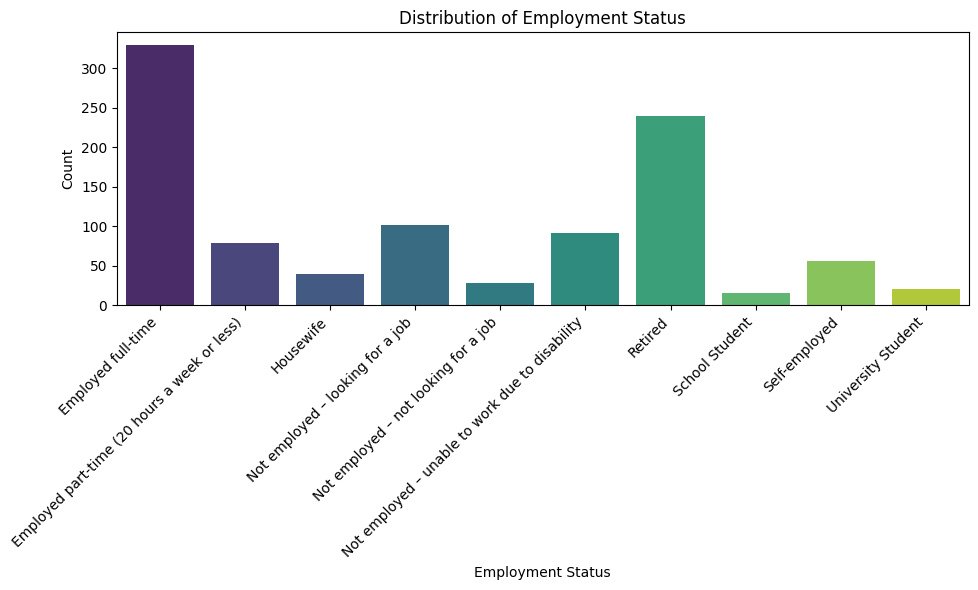

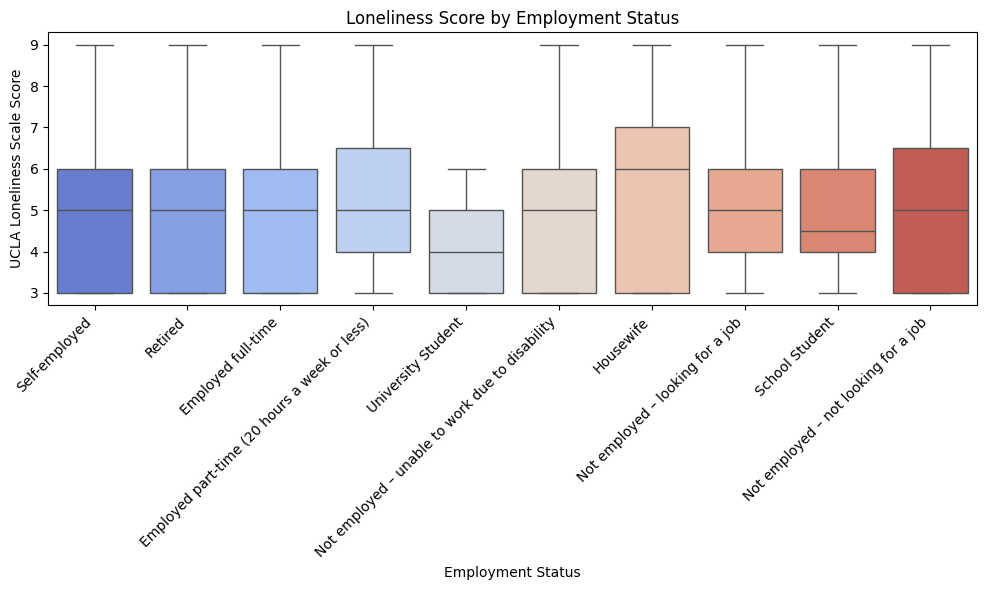

<ipython-input-11-a9979b2518a3>:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='What best describes your employment status?', y='Problematic Social Media Use Score', data=data, palette='muted')


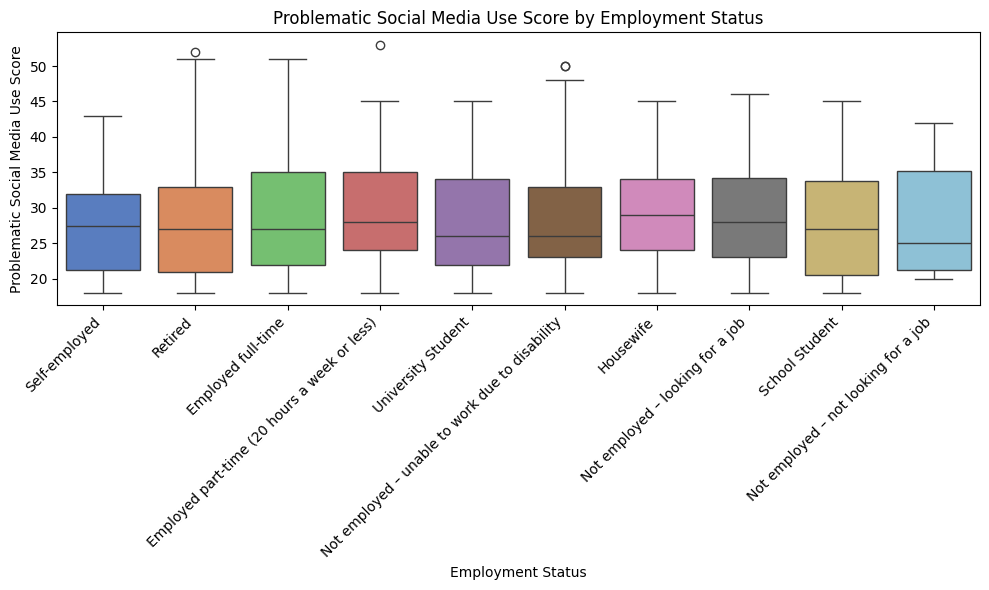

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualization of Employment Status Distribution
# plt.figure(figsize=(10, 6))
# employment_status_count = data['What best describes your employment status?'].value_counts()
# sns.barplot(x=employment_status_count.index, y=employment_status_count.values, palette='viridis')
# plt.title('Distribution of Employment Status')
# plt.xticks(rotation=45, ha='right')
# plt.ylabel('Count')
# plt.xlabel('Employment Status')
# plt.tight_layout()

plt.figure(figsize=(10, 6))
# First, sort the index (which is 'Employment Status') alphabetically
employment_status_count = data['What best describes your employment status?'].value_counts().sort_index()
# Then, create the bar plot
sns.barplot(x=employment_status_count.index, y=employment_status_count.values, palette='viridis')
plt.title('Distribution of Employment Status')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Count')
plt.xlabel('Employment Status')
plt.tight_layout()

plt.figure(figsize=(10, 6))
sns.boxplot(x='What best describes your employment status?', y='UCLA lonliness scale score', data=data, palette='coolwarm')
plt.title('Loneliness Score by Employment Status')
plt.xticks(rotation=45, ha='right')
plt.ylabel('UCLA Loneliness Scale Score')
plt.xlabel('Employment Status')
plt.tight_layout()

plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='What best describes your employment status?', y='Problematic Social Media Use Score', data=data, palette='muted')
plt.title('Problematic Social Media Use Score by Employment Status')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Problematic Social Media Use Score')
plt.xlabel('Employment Status')
plt.tight_layout()

plt.show()


### Gaming behaviour and mindsets

#### Basic Statistics Related to Gaming

<ipython-input-18-a5232c31e745>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=gaming_prevalence.values, y=gaming_prevalence.index, palette='viridis')


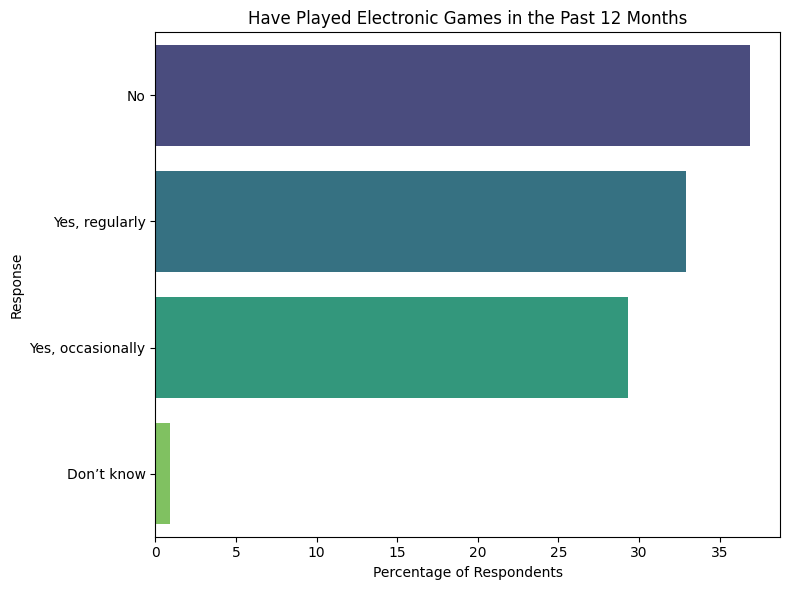

<ipython-input-18-a5232c31e745>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=primary_platforms.values, y=primary_platforms.index, palette='coolwarm')


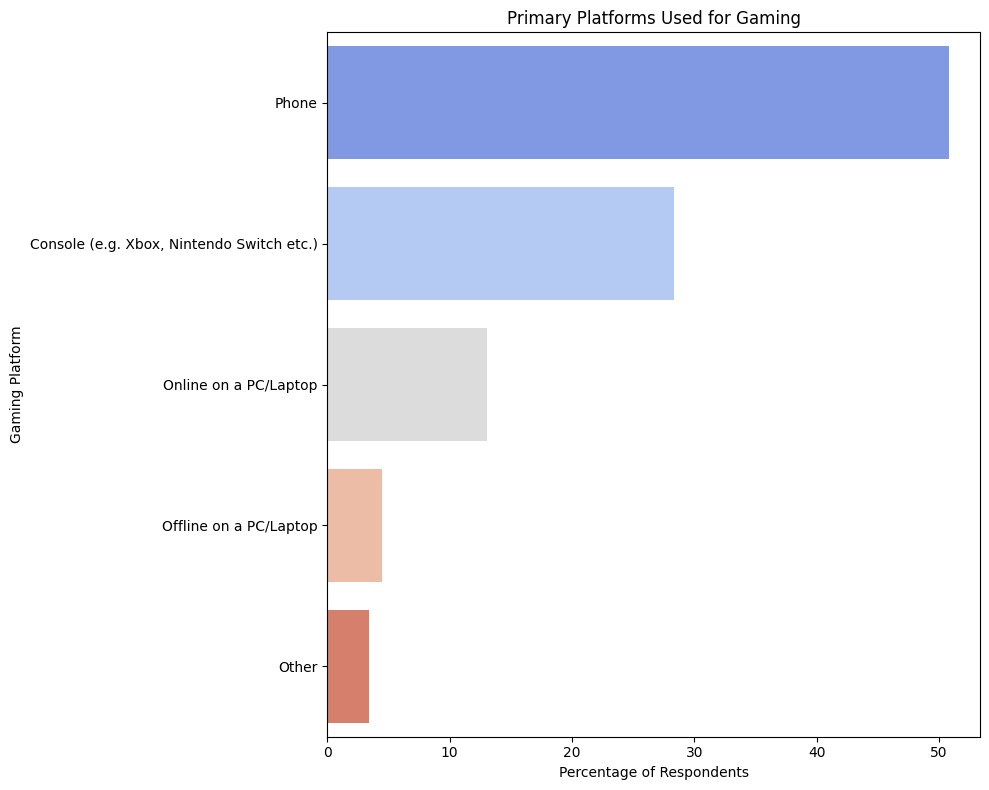

In [ ]:
gaming_prevalence = data['Have you played electronic games (online games, video games, mobile phone games, etc.) in the past 12 months?'].value_counts(normalize=True) * 100

plt.figure(figsize=(8, 6))
sns.barplot(x=gaming_prevalence.values, y=gaming_prevalence.index, palette='viridis')
plt.title('Have Played Electronic Games in the Past 12 Months')
plt.xlabel('Percentage of Respondents')
plt.ylabel('Response')
plt.tight_layout()

plt.show()


primary_platforms = data['Which of the following devices/formats is the platform you use most often to play games?'].value_counts(normalize=True) * 100

plt.figure(figsize=(10, 8))
sns.barplot(x=primary_platforms.values, y=primary_platforms.index, palette='coolwarm')
plt.title('Primary Platforms Used for Gaming')
plt.xlabel('Percentage of Respondents')
plt.ylabel('Gaming Platform')
plt.tight_layout()

plt.show()


#### Analysis: Time Spent Playing Video Games

<ipython-input-19-f26d27e139e3>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=time_spent_gaming.values, y=time_spent_gaming.index, palette='rocket')


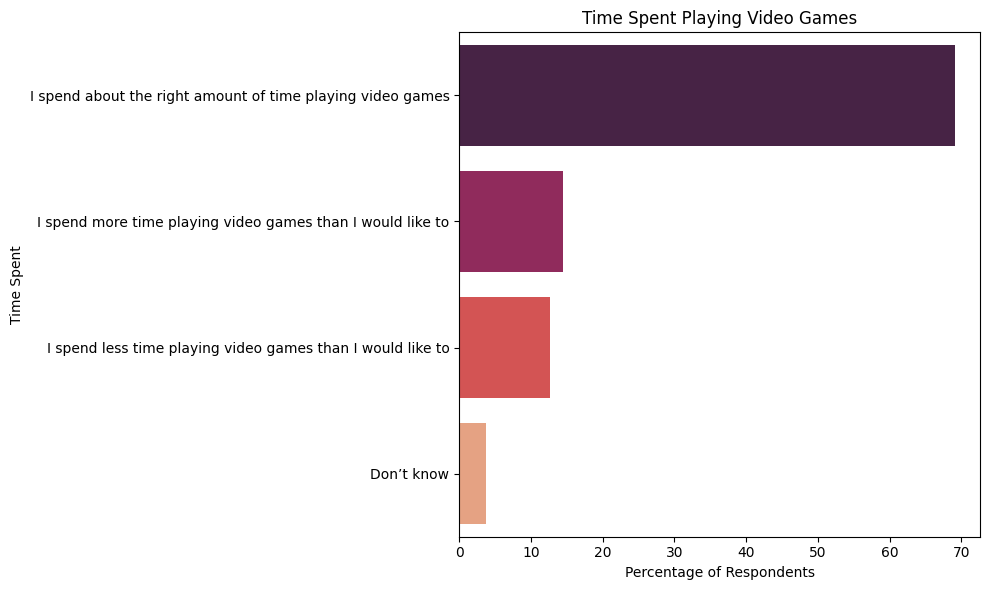

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming 'data' is your DataFrame after loading the CSV file
# Replace 'Which of the following best describes how much time you spend playing video games?'
# with the exact column name from your dataset if it's different

# Analysis: Time Spent Playing Video Games
time_spent_gaming = data['Which of the following best describes how much time you spend playing video games?'].value_counts(normalize=True) * 100

# Visualization: Time Spent Playing Video Games
plt.figure(figsize=(10, 6))
sns.barplot(x=time_spent_gaming.values, y=time_spent_gaming.index, palette='rocket')
plt.title('Time Spent Playing Video Games')
plt.xlabel('Percentage of Respondents')
plt.ylabel('Time Spent')
plt.tight_layout()

plt.show()


#### Analysis: Impact of Gaming on Hobbies and Entertainment Activities

<ipython-input-20-b283f49e331b>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=impact_on_hobbies.values, y=impact_on_hobbies.index, palette='plasma')


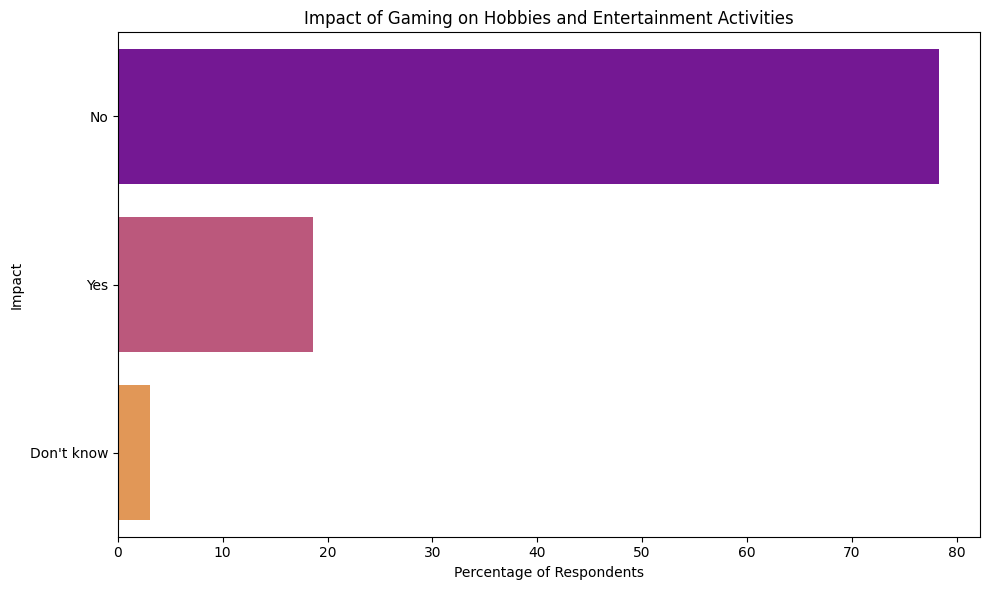

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming 'data' is your DataFrame after loading the CSV file
# Replace 'In the past 12 months, when gaming have you lost interests in previous hobbies and other entertainment activities as a result of your engagement with the game'
# with the exact column name from your dataset if it's different

# Analysis: Impact of Gaming on Hobbies and Entertainment Activities
impact_on_hobbies = data['In the past 12 months, when gaming have you lost interests in previous hobbies and other entertainment activities as a result of your engagement with the game'].value_counts(normalize=True) * 100

# Visualization: Impact of Gaming on Hobbies and Entertainment Activities
plt.figure(figsize=(10, 6))
sns.barplot(x=impact_on_hobbies.values, y=impact_on_hobbies.index, palette='plasma')
plt.title('Impact of Gaming on Hobbies and Entertainment Activities')
plt.xlabel('Percentage of Respondents')
plt.ylabel('Impact')
plt.tight_layout()

plt.show()


#### Analysis: Identity and Pride in Being a Gamer

<ipython-input-21-4e694ac5b445>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=identity_pride_gamer.values, y=identity_pride_gamer.index, palette='Spectral')


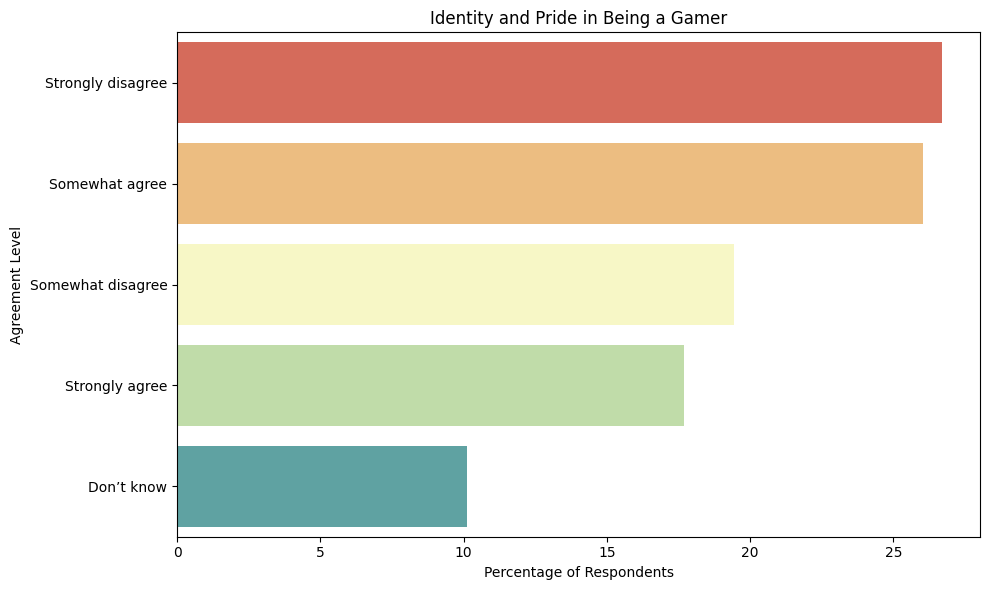

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming 'data' is your DataFrame after loading the CSV file
# Replace "I’m proud to consider myself a gamer : Do you agree or disagree with the following statements?"
# with the exact column name from your dataset if it's different

# Analysis: Identity and Pride in Being a Gamer
identity_pride_gamer = data["I’m proud to consider myself a gamer : Do you agree or disagree with the following statements?"].value_counts(normalize=True) * 100

# Visualization: Identity and Pride in Being a Gamer
plt.figure(figsize=(10, 6))
sns.barplot(x=identity_pride_gamer.values, y=identity_pride_gamer.index, palette='Spectral')
plt.title('Identity and Pride in Being a Gamer')
plt.xlabel('Percentage of Respondents')
plt.ylabel('Agreement Level')
plt.tight_layout()

plt.show()


#### Analysis: Reasons for Not Playing Electronic Games

<ipython-input-22-0b09d3558bc5>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=reasons_for_not_playing_percentage.values, y=reasons_for_not_playing_percentage.index, palette='pastel')


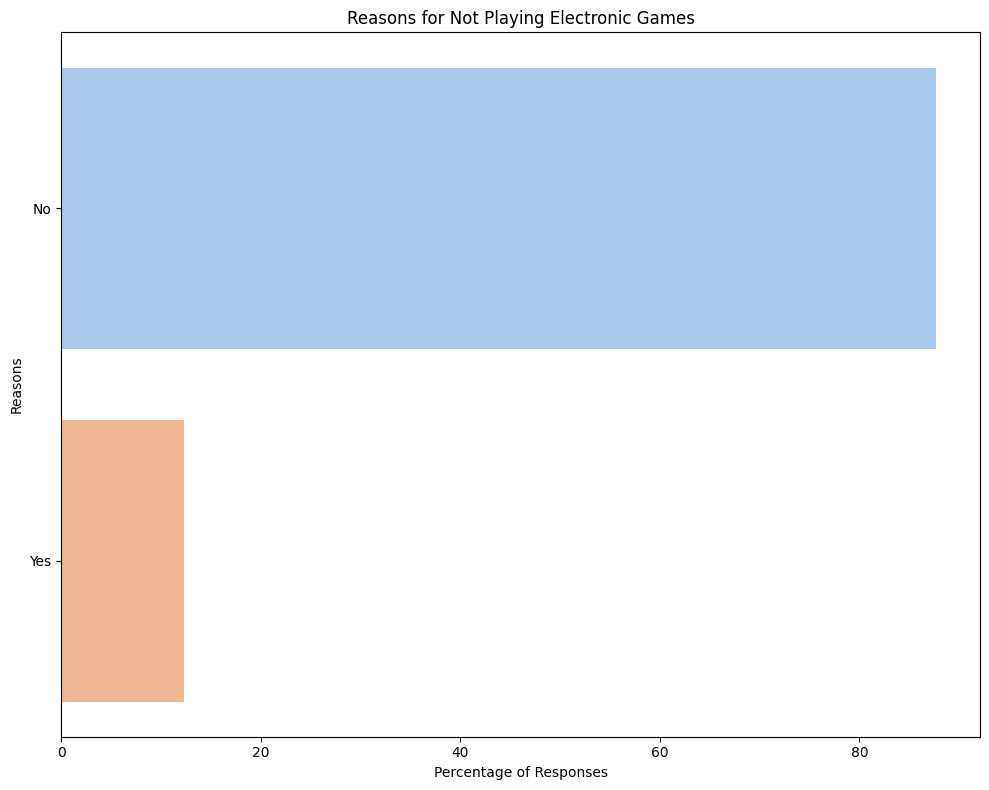

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming 'data' is your DataFrame after loading the CSV file
# Replace 'Which of the following would you say is the biggest reason why you do you not play electronic games?: ...'
# with the exact column names from your dataset if different

# Preparing and visualizing reasons for not playing electronic games
reasons_columns = [
    'Which of the following would you say is the biggest reason why you do you not play electronic games?: Not enough time to spend gaming',
    'Which of the following would you say is the biggest reason why you do you not play electronic games?: I cannot afford the games or console',
    # Add other reasons here as needed
]

# Summarizing reasons for not playing
reasons_for_not_playing = data[reasons_columns].apply(pd.Series.value_counts).fillna(0).sum(axis=1)
reasons_for_not_playing_percentage = (reasons_for_not_playing / reasons_for_not_playing.sum()) * 100

# Visualization
plt.figure(figsize=(10, 8))
sns.barplot(x=reasons_for_not_playing_percentage.values, y=reasons_for_not_playing_percentage.index, palette='pastel')
plt.title('Reasons for Not Playing Electronic Games')
plt.xlabel('Percentage of Responses')
plt.ylabel('Reasons')
plt.tight_layout()

plt.show()


### Idea of control in internal and external spheres of life and how it relates to technology

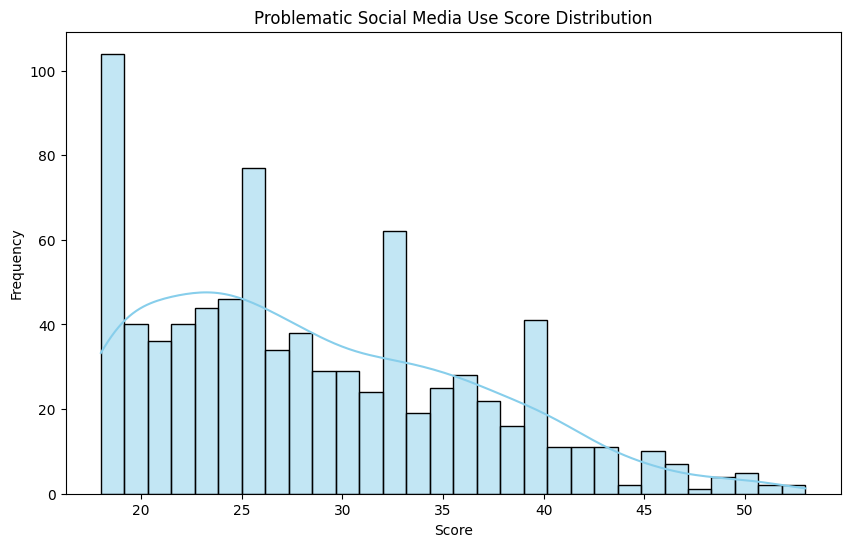

<ipython-input-23-3726276a9e33>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=distress_from_online_content.values, y=distress_from_online_content.index, palette='coolwarm')


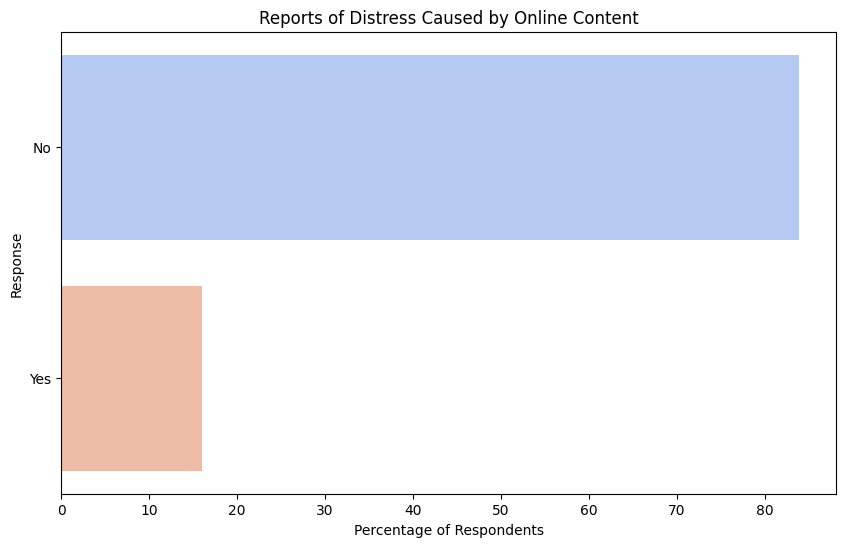

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Problematic Social Media Use Score Distribution
problematic_social_media_use = data['Problematic Social Media Use Score'].dropna()
plt.figure(figsize=(10, 6))
sns.histplot(problematic_social_media_use, bins=30, kde=True, color='skyblue')
plt.title('Problematic Social Media Use Score Distribution')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()

# Distribution of Reports of Distress Caused by Online Content
distress_from_online_content = data['This person reports having viewed content online that caused distress'].value_counts(normalize=True) * 100
plt.figure(figsize=(10, 6))
sns.barplot(x=distress_from_online_content.values, y=distress_from_online_content.index, palette='coolwarm')
plt.title('Reports of Distress Caused by Online Content')
plt.xlabel('Percentage of Respondents')
plt.ylabel('Response')
plt.show()


### Mental health and well being

#### Distribution of Anxiety and Depression Scores

In [ ]:
# Correct column names for GAD-7 and PHQ-9 scores
gad7_column = "This is the total score for Anxiety as per the GAD7 the WHO screening tool for anxiety"
phq9_column = "This is the total score for depression as per the PHQ2 the WHO screening tool for depression"


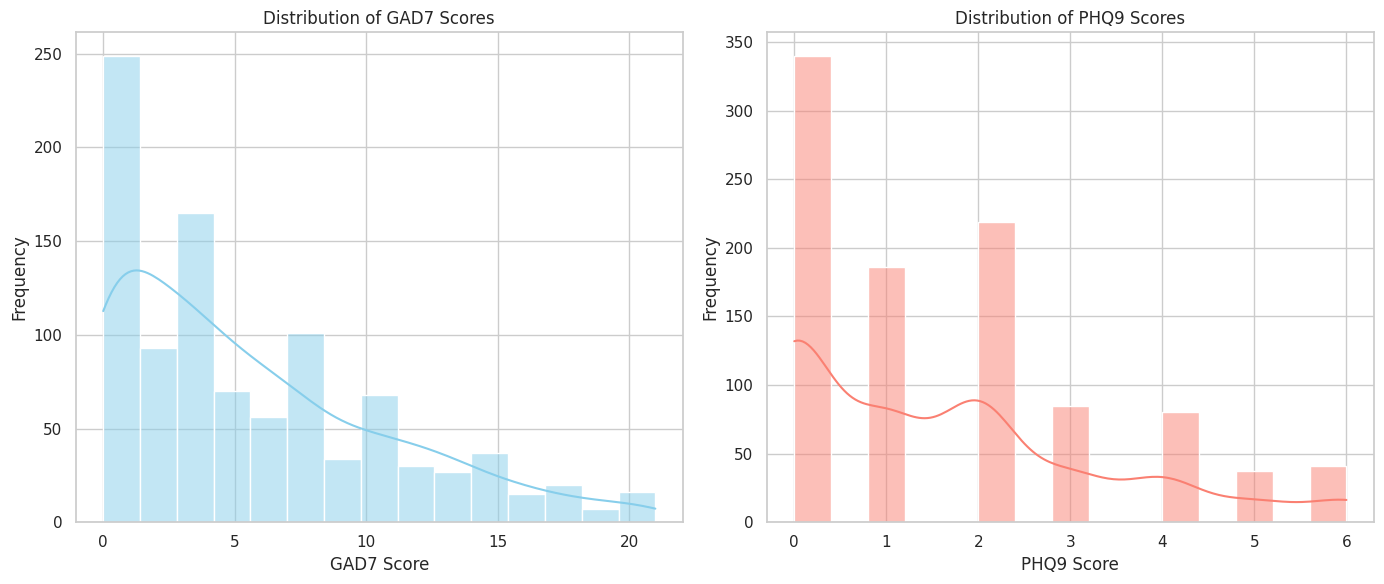

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the aesthetics for the plots
sns.set(style="whitegrid")

# Create a figure for subplots
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot distribution of GAD7 scores
sns.histplot(data=data, x=gad7_column, bins=15, kde=True, color="skyblue", ax=ax[0])
ax[0].set_title('Distribution of GAD7 Scores')
ax[0].set_xlabel('GAD7 Score')
ax[0].set_ylabel('Frequency')

# Plot distribution of PHQ9 scores
sns.histplot(data=data, x=phq9_column, bins=15, kde=True, color="salmon", ax=ax[1])
ax[1].set_title('Distribution of PHQ9 Scores')
ax[1].set_xlabel('PHQ9 Score')
ax[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


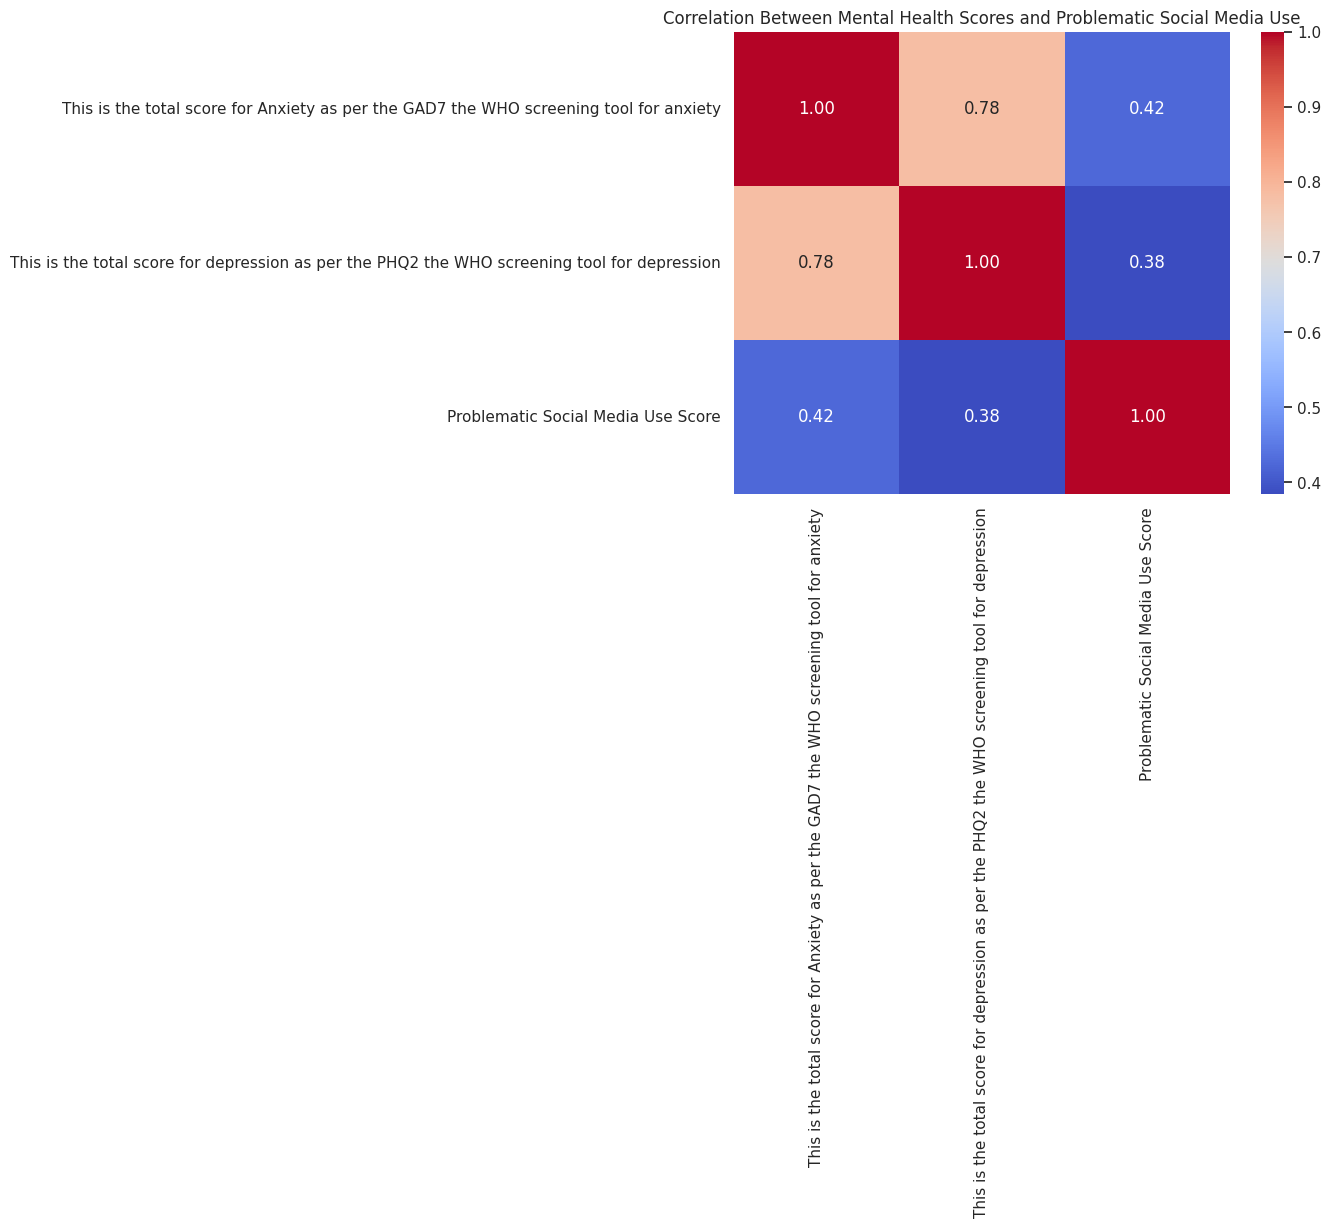

In [ ]:
# Selecting the columns for correlation analysis
columns_for_analysis = [
    gad7_column,
    phq9_column,
    "Problematic Social Media Use Score"
]

# Calculating the correlation matrix
correlation_matrix = data[columns_for_analysis].corr()

# Plotting the heatmap for the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Between Mental Health Scores and Problematic Social Media Use')
plt.show()
